# MMP registration and Polscope mask

In [6]:
import SimpleITK as sitk

import numpy as np
import numpy.ma as ma

from myshow import myshow

import os
import sys
PolDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Polscope input/"
MMPDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/MMP input/"
OutDir = "F:/Box Sync/Research/Polarimetry/Jupyter Analysis/Reg Mask Output/"

#module_path = os.path.abspath(os.path.join('C:/Users/mpinkert/Documents/GitHub/SimpleITK-Notebooks/Utilities/'))
#if module_path not in sys.path:
 #   sys.path.append(module_path)
    
#from downloaddata import fetch_data as fdata

# setup our plotting environment
import matplotlib.pyplot as plt
%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0]*2
fig_size[1] = fig_size[1]*2
plt.rcParams["figure.figsize"] = fig_size


## Utility functions

In [37]:
def polToDegree(itkImg, ceiling):
    # Change from 16 bit integer, to a degrees.
    retImg = itkImg * (ceiling/65535) * (4/549) * 90
    return retImg

In [35]:
# GUI components (sliders, dropdown...).
from ipywidgets import interact, fixed

# Enable display of HTML.
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixedITK, movingITK):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2)
    
    fixed_npa = sitk.GetArrayFromImage(fixedITK)
    moving_npa = sitk.GetArrayFromImage(movingITK)
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()
    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:] + alpha*moving[:,:] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_images_with_color(fixed,moving):
    img[:,:,1] = fixed
    img[:,:,2] = moving
    
    
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations

#def convertToDegrees(polImg, retCeiling)



## Read images

Read in the fixed (Polscope) and moving (MMP) images.  The Polscope images need to be converted from nanometers to degrees, to be on the same scale as the MMP images.

In [75]:
sample = 'WP2'

fixed = polToDegree(sitk.ReadImage(PolDir + sample + '_35nm_10x.tif', sitk.sitkFloat32),35)
moving = sitk.ReadImage(MMPDir + sample + '_MMP.tif')

fixed.SetSpacing([6,6,1])
moving.SetSpacing([5.57,5.57,1])

## Display initial image pairs

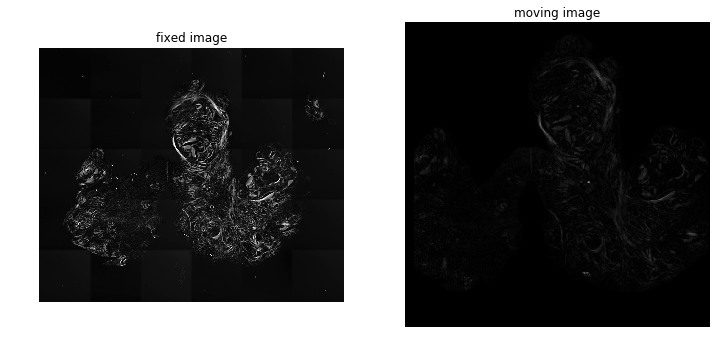

In [76]:
display_images(fixed, moving)

## Affine Registration

In [77]:
def affine_registration(fixed_image,moving_image):
    registration_method = sitk.ImageRegistrationMethod()

     # Similarity metric settings.|
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)

    registration_method.SetInterpolator(sitk.sitkLinear)

        # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        #Redefining initial_transform so the function 
    initial_transform = sitk.AffineTransform(2)

        # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    #affine_transform = registration_method.Execute(fixed_image,moving_image)
    #print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    #print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

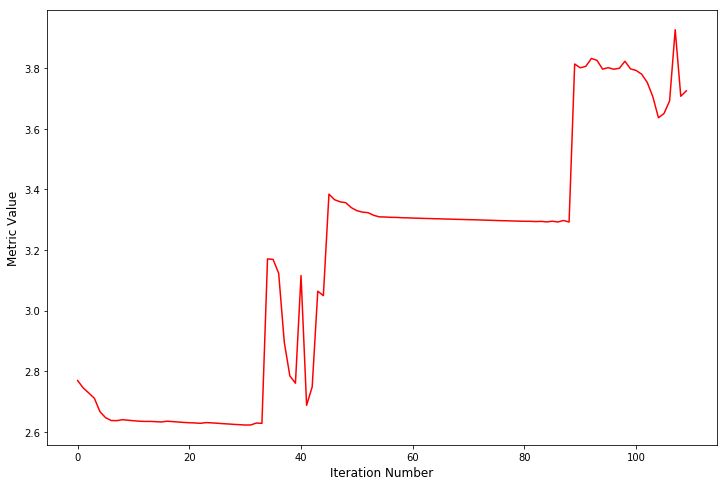

Final metric value: 3.8032653196796726
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 21.


In [78]:
(transform, metric, stop) = affine_registration(WP2_fixed,WP2_moving)
print('Final metric value: {0}'.format(metric))
print('Optimizer\'s stopping condition, {0}'.format(stop))
#print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
#print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


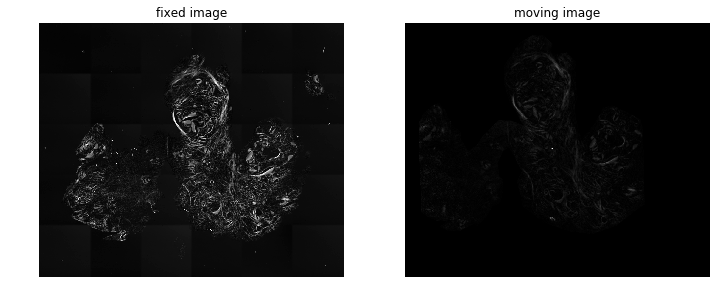

In [79]:
registered = sitk.Resample(moving, fixed, transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
display_images(fixed, registered)

C:\Users\mpinkert\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cm.py:260: RuntimeWarning: overflow encountered in multiply
  xx = (xx * 255).astype(np.uint8)


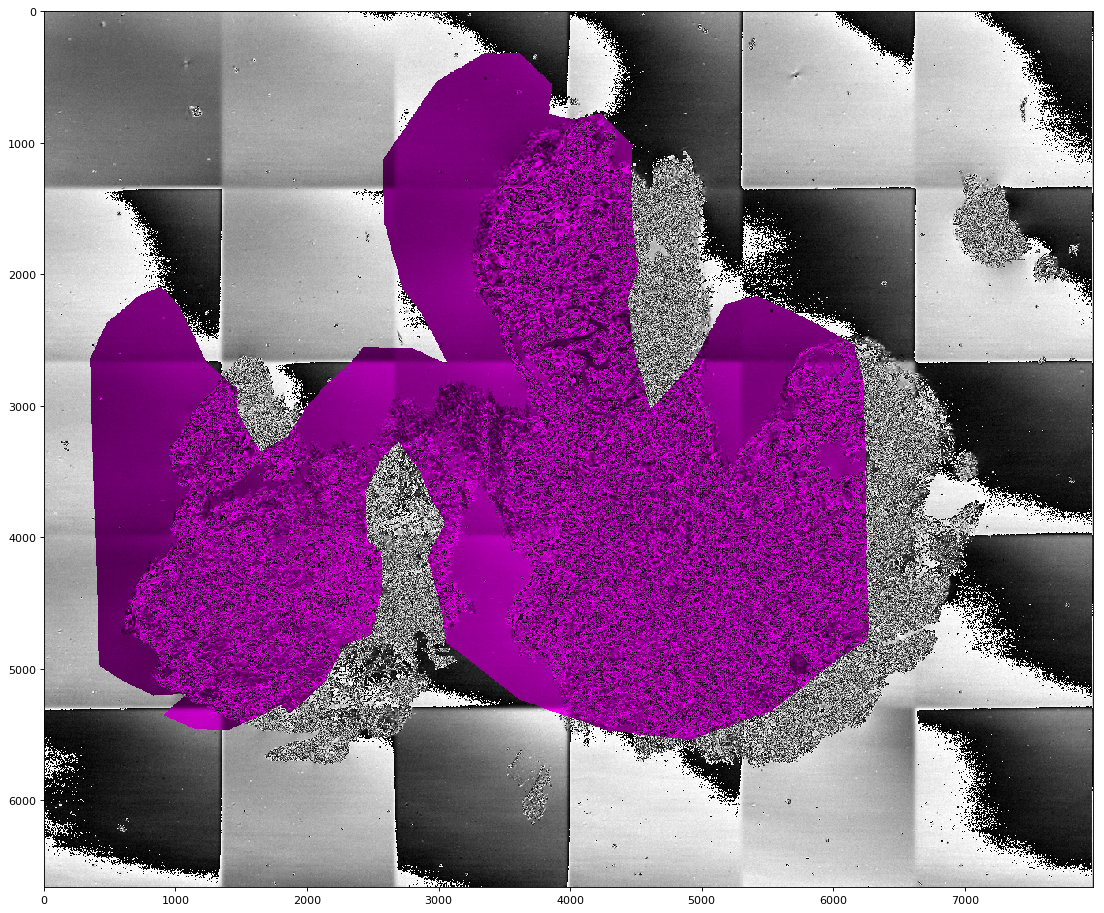

In [80]:
mask = registered > 0
myshow(sitk.LabelOverlay(fixed,mask))

In [8]:
writer = sitk.ImageFileWriter()
#writer.SetFileName(OutDir + 'jupyterAffine_mean_4Pyramid_gradDes_lr1_conMin-1e-6_.tif')
#writer.Execute(affine_resampled)